# Electrophysiology introduction
This notebook introduces EEG data analysis by walking through computing an event-related potential (ERP). We import an example dataset containing an intracranial recording from a subject engaged in a visual target detection task, and compute the ERP in response to a target and a standard stimulus. Standard packages (numpy, scipy, and matplotlib) are introduced; basic printing and plotting are demonstrated; and an intuitive analysis requiring indexing and averaging is provided.

## Set-up

### Download data / code repository

In [1]:
# We begin by 'cloning' the GitHub repository for this workshop.
# This will download the data we will be analyzing in this notebook
!git clone https://github.com/mwprestonjr/ephys_workshop.git
%cd ephys_workshop

[WinError 2] The system cannot find the file specified: 'ephys_workshop'
c:\Users\micha\projects\ephys_workshop\notebooks


### Import packages

In [2]:
# Next we import the necessary packages for our analysis
import numpy as np # for general computing
import matplotlib.pyplot as plt # for plotting
import scipy.io as sio # for loading data


### Load dataset

In [3]:
# Here we load the example dataset. This dataset contains an intracranial EEG
# recording (one channel) from a subject engaged in a target detection task.

# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000

# Load dictionary containing experimental data
# data_in = sio.loadmat('data/ecog_data.mat', squeeze_me=True)
data_in = sio.loadmat('../data/ecog_data.mat', squeeze_me=True) # TEMP

# Assign neural and behavioral data arrays to variables
data = data_in['data'] # Neural data from one channel (voltage v. time)
standard_stim = data_in['sta'] # Time index of standard stimuli events
target_stim = data_in['tar'] # Time index of target stimuli event 
response = data_in['resp'] # Time index of behavioral responses

# print dataset details
n_seconds = len(data) / fs # dividing by the sampling frequnecy (fs) converts the index to time in seconds
print(f"N seconds: {n_seconds}")
print(f"N standard stimuli: {len(standard_stim)}")
print(f"N target stimuli: {len(target_stim)}")
print(f"N response times: {len(response)}")

N seconds: 1459.92
N standard stimuli: 380
N target stimuli: 117
N response times: 117


[  3.46000338   2.36433768   0.03803496 ...  11.55540848  -3.73713207
 -13.35820961]


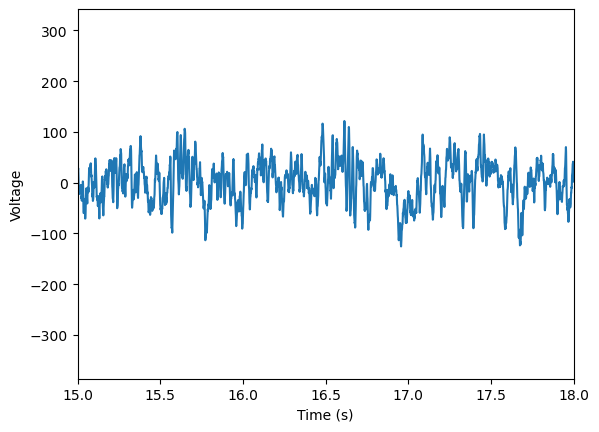

In [9]:
# Visualize EEG time-series

# show data array
print(data)

# plot time-series
time_points = np.arange(len(data)) / fs # define time points for EEG data
plt.plot(time_points, data) # plot data
plt.xlim((15,18)) # limit x-range to show 3 second snippet of data only
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

[369683 371912 383777 385253 385591 387681 389756 392031 395058 404634]


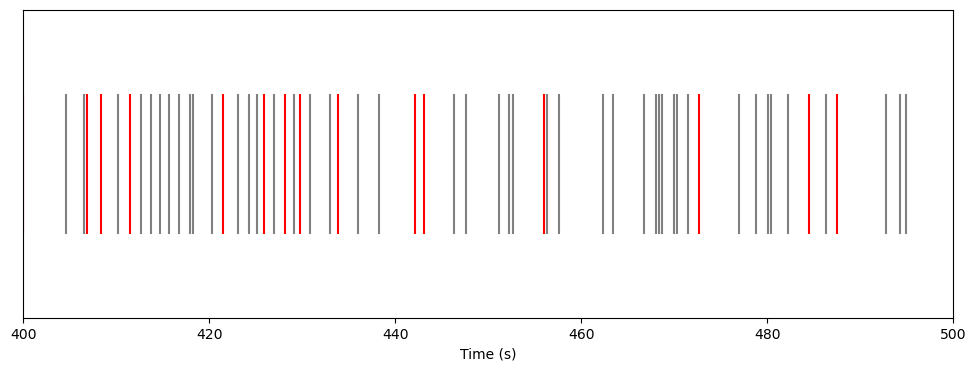

In [12]:
# visualize stimulus data

# show array
print(standard_stim[:10])

# plot stimulus times
plt.figure(figsize=[12,4])
plt.eventplot(standard_stim / fs, color='grey') # dividing by the sampling frequnecy (fs) converts the index to time in seconds
plt.eventplot(target_stim / fs, color='r')
plt.xlim((400, 500)) 
plt.xlabel('Time (s)')
plt.yticks([])
plt.show()

## Event-related potential (ERP) analysis
In this section we will compute and plot the ERP. We will compare the ERP in response to the target and standard stimuli. 

Time of first target stimuli: 370.021 s


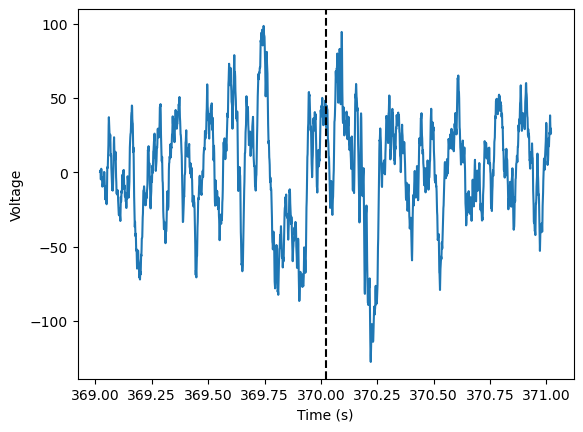

In [6]:
# plot response to target stimuli

# get data window (epoch) around stimulus time
print(f"Time of first target stimuli: {target_stim[0] / fs} s")
time_window = 1 * fs # take 1 second window before/after the stimulus time
idx_stim = target_stim[0] # get index of first stimuli
idx_start = idx_stim - time_window # index of epoch start
idx_end =  idx_stim + time_window # index of epoch end
erp_0 = data[idx_start : idx_end] # get ERP response to first target stimuli
erp_time = time_points[idx_start : idx_end] # get associated time points

# plot
plt.plot(erp_time, erp_0) # plot ERP
plt.axvline(idx_stim/fs, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

We see that the evoked response on a single trial is quite small and difficult to serarate from noise. Next, we will compute the ERP by averaging over many responses to the same stimulus. 

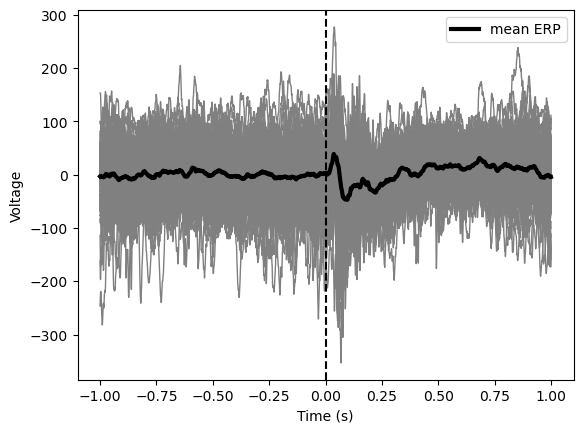

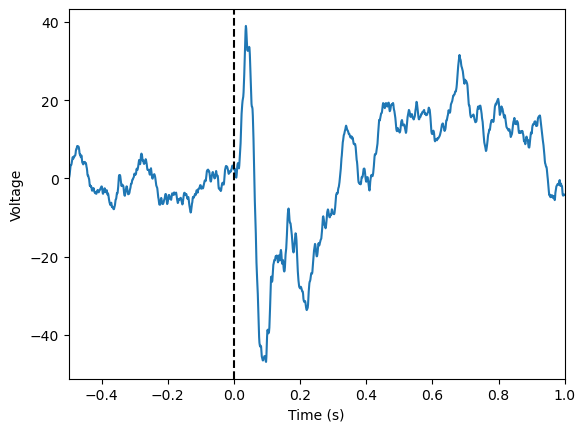

In [7]:
# compute average response to target stimulus

# initialize matrix to store response to each stimuli
n_samples = time_window * 2
evoked_responses = np.zeros([len(target_stim), n_samples]) 

# loop through each stimulus and store response
for ii, idx_stim in enumerate(target_stim):
    idx_stim = target_stim[ii] # get index of current stimuli
    idx_start = idx_stim - time_window
    idx_end =  idx_stim + time_window
    evoked_responses[ii] = data[idx_start : idx_end] # get ERP response to current target stimuli and store

# average response across trials
erp = np.mean(evoked_responses, axis=0)

# plot individual responses and mean ERP
erp_time = (np.arange(len(erp))/fs) - (time_window/fs) # define time vector
plt.plot(erp_time, evoked_responses.T, color='grey', linewidth=1) # plot ERP
plt.plot(erp_time, erp, color='k', linewidth=3, label='mean ERP') # plot ERP
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

# plot ERP - zoom in on response
plt.figure()
plt.plot(erp_time, erp) # plot ERP
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.xlim([-0.5, 1])
plt.show()

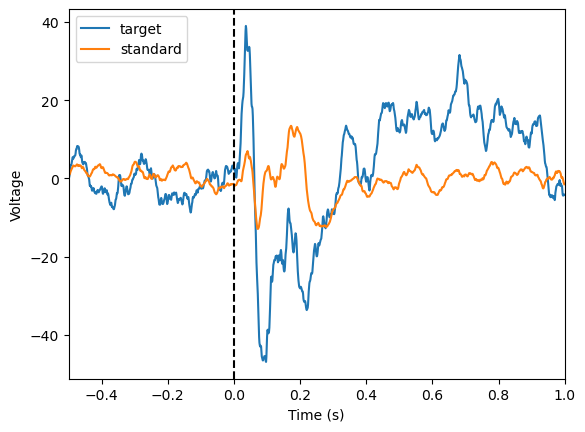

In [8]:
# compare ERP of target and response stimulus

# rename
erp_target = erp

# loop through each stimulus and store response
evoked_responses = np.zeros([len(standard_stim), n_samples]) 
for ii, idx_stim in enumerate(target_stim):
    idx_stim = standard_stim[ii] # get index of current stimuli
    idx_start = idx_stim - time_window
    idx_end =  idx_stim + time_window
    evoked_responses[ii] = data[idx_start : idx_end] # get ERP response to current target stimuli and store

# average response across trials
erp_standard = np.mean(evoked_responses, axis=0)

# plot ERPs
plt.figure()
plt.plot(erp_time, erp_target, label='target') # plot ERP for target stimulus
plt.plot(erp_time, erp_standard, label='standard') # plot ERP for standard stimulus
plt.axvline(0, linestyle='--', color='k') # draw vertical line at stimulus time
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.xlim([-0.5, 1])
plt.legend()
plt.show()